In [1]:
import pandas as pd
import numpy as np 
import random 
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math 
from collections import defaultdict
import json, math, gdown
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import re

random.seed(416)
np.random.seed(416)

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)

def clean_vars(s, how='title'):
    """
    Simple function to clean titles

    Params
    - s: The string to clean
    - how (default='title'): How to return string. Can be either ['title', 'lowercase', 'uppercase']

    Returns
    - cleaned string
    """
    assert how in ['title', 'lowercase', 'uppercase'], "Bad option!! see docs"
    s = re.sub('([a-z0-9])([A-Z])', r'\1 \2', s)
    s = s.replace('_', ' ')
    if how == 'title':
        return s.title()
    elif how=='lower':
        return s.lower()
    elif how=='upper':
    	return s.upper()
    
make_aesthetic()


# Data Merging

Add open or closed

In [2]:
df = pd.read_json("clean_battle_20240313.json", dtype={'tstamp':'object'})
meta_df = pd.read_csv("model_names_annot.csv")


# We need to merge meta_df on model_a and model_b
for col in meta_df.columns:
    meta_df[col] = meta_df[col].apply(lambda x: x.strip())
    meta_df[f"a_{col}"] = meta_df[col]
    meta_df[f"b_{col}"] = meta_df[col]

df = pd.merge(df, meta_df[['a_short_name', 'a_open_or_closed', "a_long_name"]], left_on=['model_a'], right_on=['a_long_name'])
df = pd.merge(df, meta_df[['b_short_name', 'b_open_or_closed', "b_long_name"]], left_on=['model_b'], right_on=['b_long_name'])
df.to_csv("all_annot.csv")
df.sample(30).to_csv("all_annot_sample.csv")

# Data Wrangling

In [3]:
def print_dates(df):
    print("MIN AND MAX DATES")
    print(df['tstamp_fix'].min())
    print(df['tstamp_fix'].max())

def label_battle(x):
    a_type = x['a_open_or_closed']
    b_type = x['b_open_or_closed']
    model_types = [a_type, b_type]
    model_set = set(model_types)
    
    if len(model_set) == 2:
        return "open_closed"
    elif model_set == {"open"}:
        return "open_open"
    elif model_set == {"closed"}:
        return "closed_closed"

####################
# Exclusion criteria 
####################
df = df[df['anony']==True]
df = df[df['b_open_or_closed'] != '-1']
df = df[df['a_open_or_closed'] != '-1']

####################
# Adding fields for 
# date and battle type
####################
df['tstamp_fix'] = pd.to_datetime(df['tstamp'].astype(float), unit='s')
df['segment'] = df['tstamp_fix'].dt.floor('30D')
df['segment_int'] = pd.factorize(df['segment'])[0]+1
df['battle_type'] = df.apply(lambda x: label_battle(x), axis=1)


# Descriptives

TOTAL COUNT 369564
battle_type
closed_closed    0.407264
open_closed      0.356707
open_open        0.236029
Name: proportion, dtype: float64


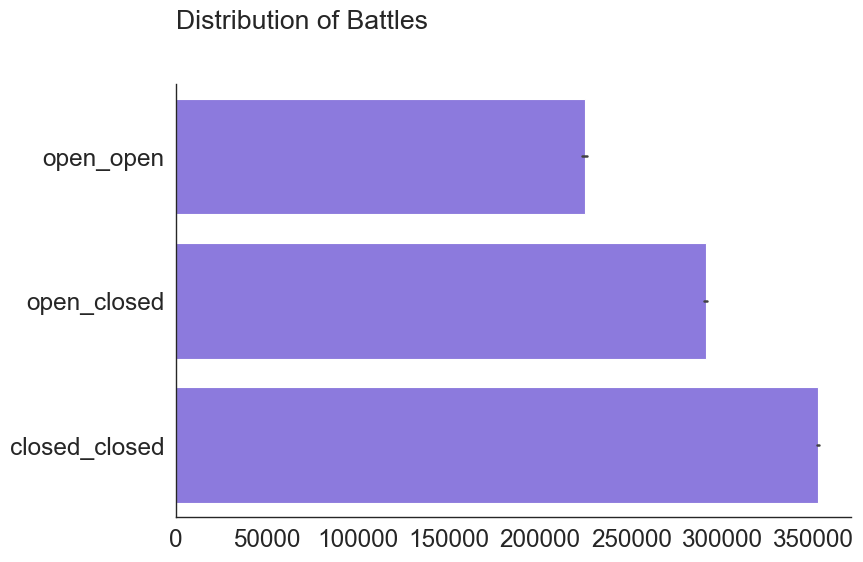

a_open_or_closed
closed    0.585915
open      0.414085
Name: proportion, dtype: float64


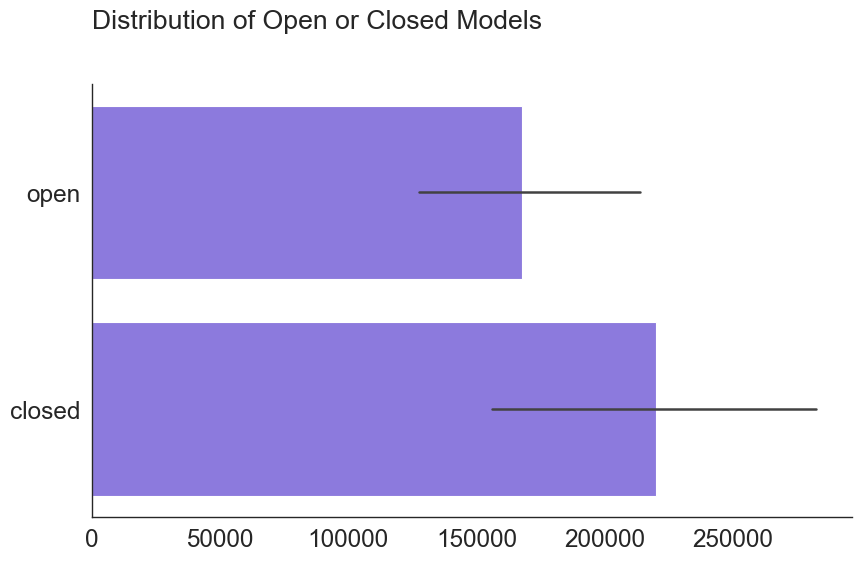

Mean 5435, Median 3409, SD 4979, Min 239, Max 23786


Text(0.0, 1.0, 'Count of Models')

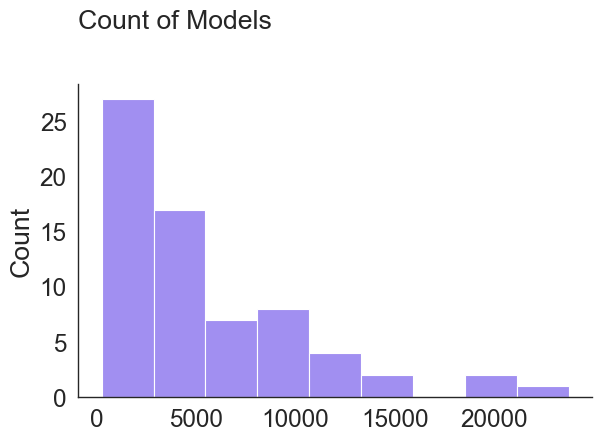

In [4]:
def count_plot(data, dv, clean_title, fig_size=(9,6)):
    plt.figure(figsize=fig_size)
    sns.barplot(data[dv])
    plt.title(clean_title)
    plt.ylabel("")
    plt.show()


print("TOTAL COUNT", len(df))
    
# Count of battles
print(df['battle_type'].value_counts(normalize=True))
count_plot(df, dv="battle_type", clean_title="Distribution of Battles")

# Count of open or closed models
print(df['a_open_or_closed'].value_counts(normalize=True))
count_plot(df.drop_duplicates(subset=['model_a']), dv="a_open_or_closed", clean_title="Distribution of Open or Closed Models")

# Count of models 
model_counts = sorted(df['model_a'].value_counts().to_list())
print(f"Mean {np.mean(model_counts):.0f}, Median {np.median(model_counts):.0f}, SD {np.std(model_counts):.0f}, Min {np.min(model_counts):.0f}, Max {np.max(model_counts):.0f}")
sns.histplot(model_counts)
plt.title("Count of Models")



# Elo Scores

These functions are improted from the original notebook. 

## Functions

In [5]:
def compute_mle_elo(df, SCALE=400, BASE=10, INIT_RATING=1000):
    df = df.sort_values(ascending=True, by=['tstamp'])
    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0

    # one tie => one A win + one B win
    # find tie + tie (both bad) index
    tie_idx = (df["winner"] == "tie") | (df["winner"] == "tie (bothbad)")
    tie_idx[len(tie_idx)//2:] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False)
    lr.fit(X,Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as llama-2-70b-chat = 1082
    if "llama-2-70b-chat" in models.index:
        elo_scores += 1082 - elo_scores[models["llama-2-70b-chat"]]
    return pd.Series(elo_scores, index = models.index).sort_values(ascending=False)

def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


## Compute for slices

In [6]:
dfs = []
for slice in df['segment'].unique():
    tdf = df[df['segment'] == slice]
    elo_mle_ratings = compute_mle_elo(tdf)
    elo_df = pd.DataFrame(elo_mle_ratings).reset_index()
    elo_df.columns = ['model', 'elo']
    elo_df['segment'] = slice
    dfs.append(elo_df)

elo_df_m = pd.concat(dfs)
elo_df_m2 = pd.merge(elo_df_m, meta_df[['short_name', 'open_or_closed', "long_name"]], left_on=['model'], right_on=['long_name'])
elo_df_m2['segment_int'] = pd.factorize(elo_df_m2['segment'])[0]


## Graph overall

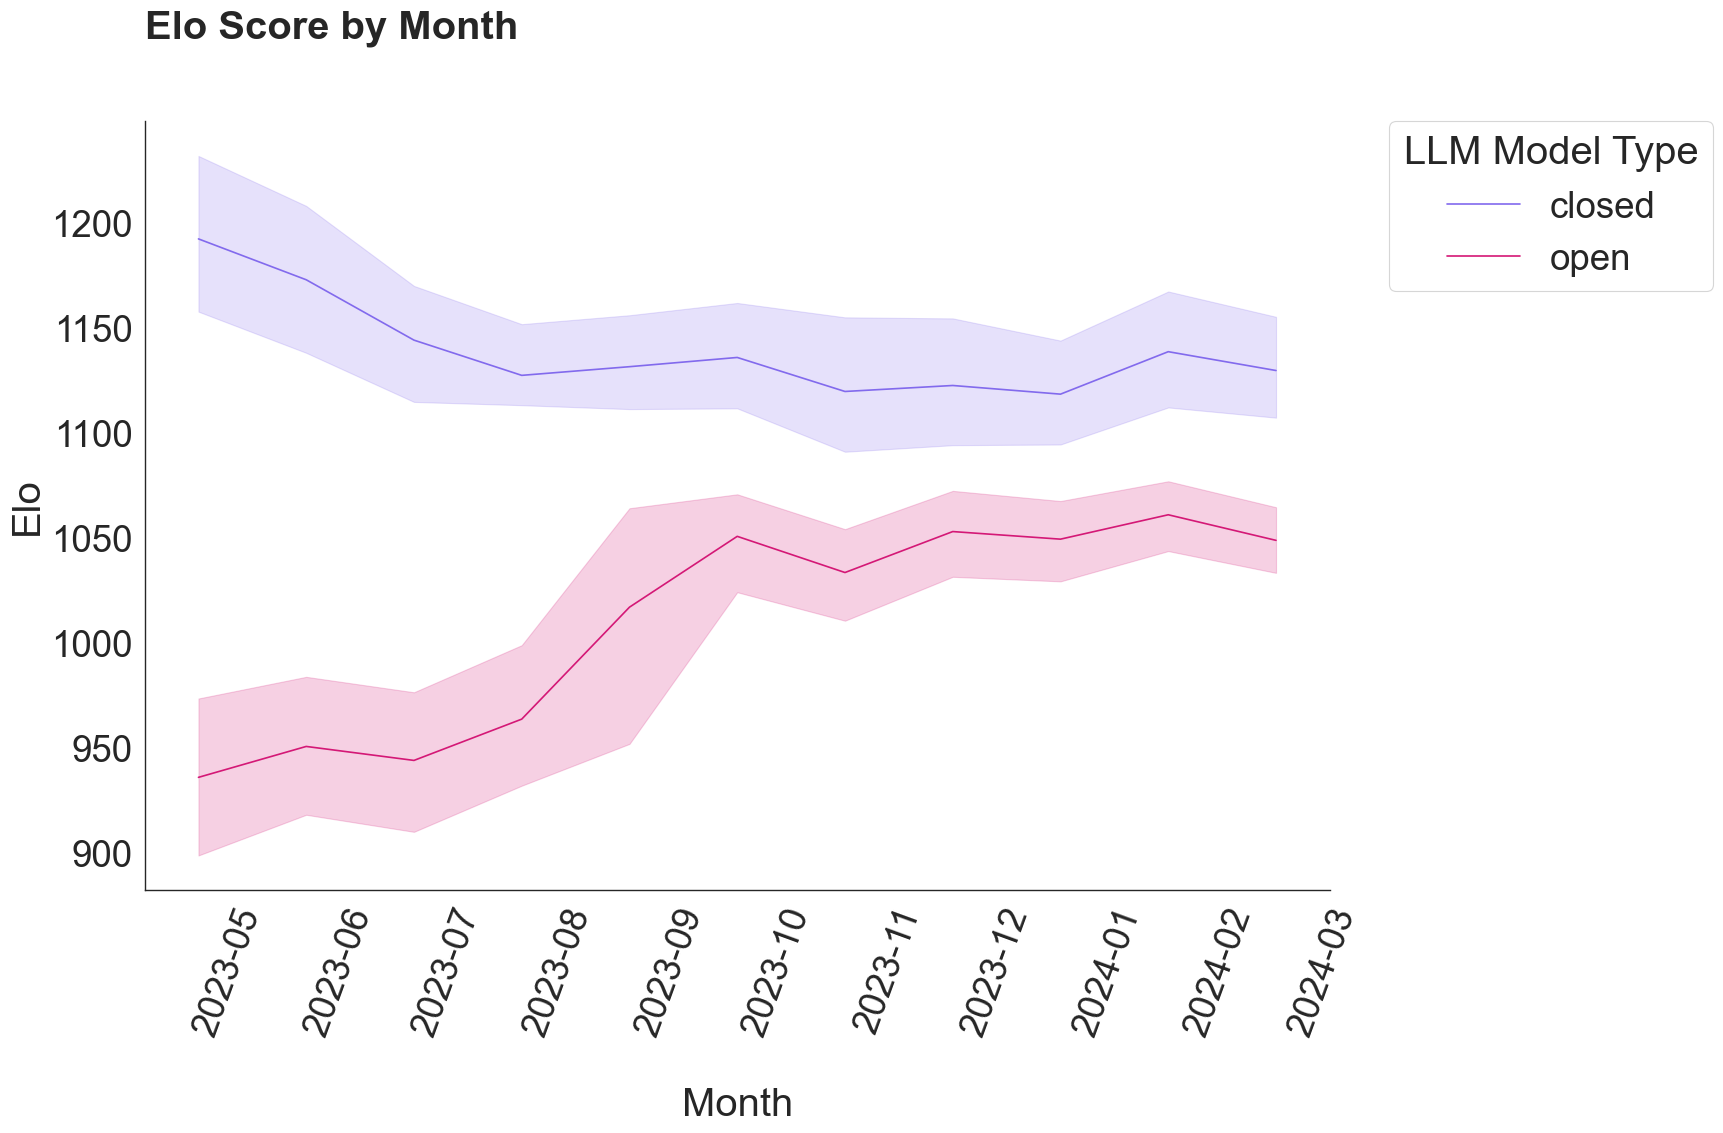

In [7]:
plt.figure(figsize=(18,12))
make_aesthetic(font_scale=3)
sns.lineplot(data=elo_df_m2, x='segment', y='elo', hue='open_or_closed')
plt.title("Elo Score by Month", fontweight='bold')
plt.xlabel("\nMonth")
plt.xticks(rotation=70)
plt.ylabel("Elo")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="LLM Model Type")
plt.tight_layout()  
plt.show()

# Bootstrap ratios

In [8]:
elo_df_m2.to_csv("elo_df.csv")

In [9]:
import numpy as np

# Filter the dataset into open and closed subsets
closed_df = elo_df_m2[elo_df_m2['open_or_closed'] == 'closed']
open_df = elo_df_m2[elo_df_m2['open_or_closed'] == 'open']

##################################
# bootstrap results
##################################
import numpy as np

def bootstrap_ratios(closed_group, open_group, n=1000):
    mean_ratios = []
    closed_scores = []
    open_scores = []

    for _ in range(n):
        closed_sample = closed_group['elo'].sample(len(closed_group), replace=True)
        open_sample = open_group['elo'].sample(len(open_group), replace=True)

        closed_mean = closed_sample.mean()
        open_mean = open_sample.mean()

        mean_ratios.append(open_mean / closed_mean)
        closed_scores.append(closed_mean)
        open_scores.append(open_mean)

    # Calculate the mean ratio and its confidence interval
    mean_rat = np.mean(mean_ratios)
    lower_mean_rat, upper_mean_rat = np.percentile(mean_ratios, [2.5, 97.5])

    # Calculate the mean and confidence interval for closed scores
    mean_closed = np.mean(closed_scores)
    lower_mean_closed, upper_mean_closed = np.percentile(closed_scores, [2.5, 97.5])

    # Calculate the mean and confidence interval for open scores
    mean_open = np.mean(open_scores)
    lower_mean_open, upper_mean_open = np.percentile(open_scores, [2.5, 97.5])

    return {
        'mean_ratio': mean_rat,
        'mean_ratio_lower': lower_mean_rat,
        'mean_ratio_upper': upper_mean_rat,
        'mean_closed': mean_closed,
        'mean_closed_lower': lower_mean_closed,
        'mean_closed_upper': upper_mean_closed,
        'mean_open': mean_open,
        'mean_open_lower': lower_mean_open,
        'mean_open_upper': upper_mean_open
    }


    


##################################
# run for each segment
##################################
bootstrap_results = []
for segment in elo_df_m2['segment'].unique():
    closed_group = closed_df[closed_df['segment'] == segment]
    open_group = open_df[open_df['segment'] == segment]

    res = bootstrap_ratios(closed_group, open_group)
    res.update({
        'segment': segment,
        'closed_mean': closed_group['elo'].mean(),
        'open_mean': open_group['elo'].mean(),
    })

    bootstrap_results.append(res)

bootstrap_df = pd.DataFrame(bootstrap_results)

In [10]:
bootstrap_df

,mean_ratio,mean_ratio_lower,mean_ratio_upper,mean_closed,mean_closed_lower,mean_closed_upper,mean_open,mean_open_lower,mean_open_upper,segment,closed_mean,open_mean
0,0.785982,0.744036,0.829628,1191.989211,1157.589299,1231.682560,936.597893,899.333932,975.609079,2023-04-23,1192.205650,935.931450
1,0.811047,0.776133,0.848164,1172.856428,1137.987758,1207.898977,951.017459,918.849615,983.222235,2023-05-23,1172.755688,950.641232
2,0.826058,0.790617,0.862925,1144.122758,1113.772769,1168.808591,944.959844,909.380925,979.659411,2023-06-22,1144.023991,943.990670
3,0.853880,0.820790,0.886109,1127.317692,1113.066374,1151.616563,962.507608,930.346811,993.691534,2023-07-22,1127.259602,963.640114
4,0.899356,0.835819,0.946650,1132.229772,1111.199829,1155.873375,1018.178902,948.509702,1066.172455,2023-08-21,1131.384609,1016.929623
5,0.924717,0.892323,0.952987,1136.462136,1111.563940,1159.990910,1050.773800,1023.479267,1071.835742,2023-09-20,1135.777425,1050.639137
6,0.922560,0.886922,0.954385,1119.647008,1088.970713,1153.997049,1032.729069,1006.832480,1053.588750,2023-10-20,1119.589043,1033.417654
7,0.937813,0.905150,0.968549,1122.808116,1094.040027,1155.398951,1052.774694,1030.577054,1073.404358,2023-11-19,1122.437472,1052.912957
8,0.938287,0.910058,0.966344,1119.018247,1093.207356,1149.417485,1049.791044,1031.949869,1066.793831,2023-12-19,1118.317476,1049.297841
9,0.932776,0.906809,0.959131,1137.798481,1109.402690,1166.841892,1061.137765,1043.380138,1076.144002,2024-01-18,1138.528010,1060.908385


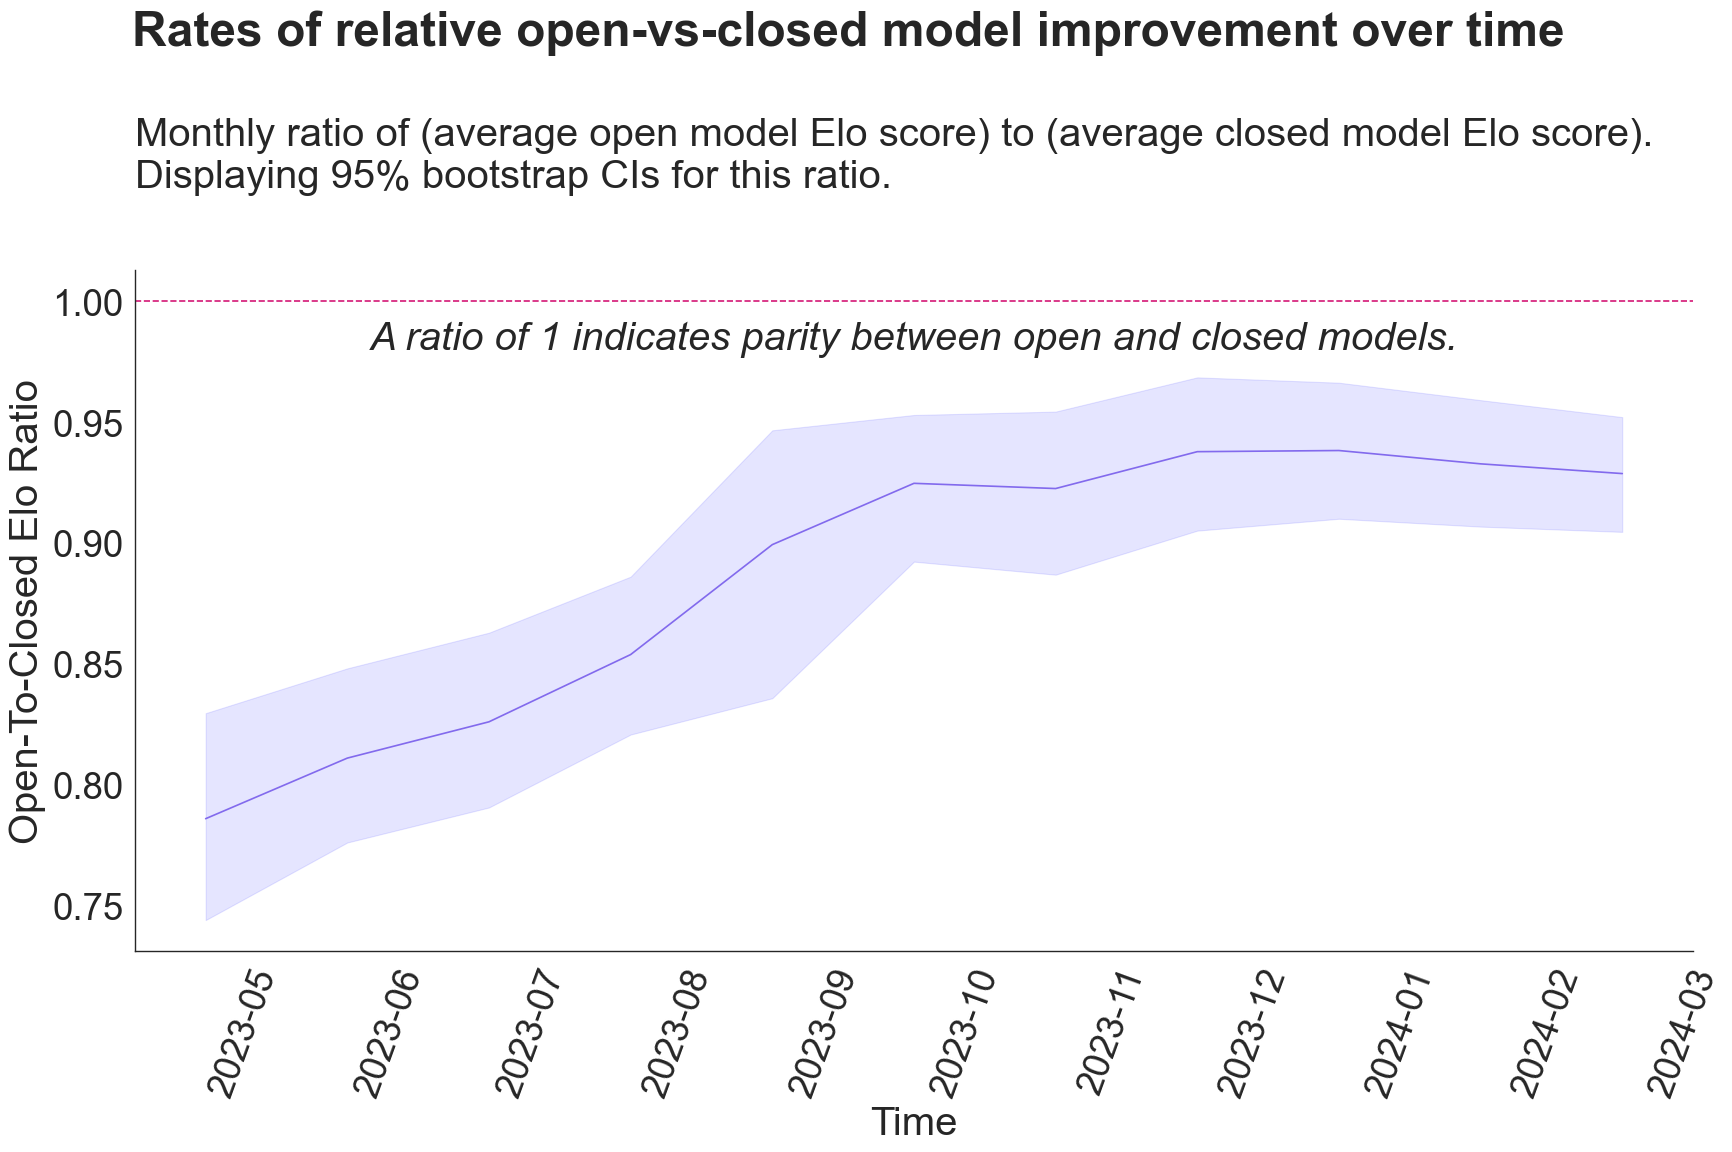

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
sns.lineplot(data=bootstrap_df, x='segment', y='mean_ratio')

plt.fill_between(
    bootstrap_df['segment'], 
    bootstrap_df['mean_ratio_lower'], 
    bootstrap_df['mean_ratio_upper'], 
    color='blue', 
    alpha=0.1, 
    label='Bootstrap 95% Confidence Interval'
)

make_aesthetic(font_scale=3)
plt.suptitle("Rates of relative open-vs-closed model improvement over time", x=0.49, fontweight='bold')
plt.title("Monthly ratio of (average open model Elo score) to (average closed model Elo score).\nDisplaying 95% bootstrap CIs for this ratio.")

plt.xlabel("Segment")
plt.ylabel("Open-To-Closed Elo Ratio")
plt.axhline(y=1, color='#D41876', linestyle='dashed')
# plt.legend(["Ratio", "95% Bootstrap CI"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time")
plt.xticks(rotation=70)

x_pos = bootstrap_df['segment'].iloc[len(bootstrap_df) // 2]

# Add annotation with an arrow
plt.annotate(
    text='A ratio of 1 indicates parity between open and closed models.', 
    xy=(x_pos, 1),  # Pointing to the line at y=1
    xytext=(x_pos, 0.98),  # Adjust text position as needed
    fontstyle='italic',  # Make text italic
    arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='angle,angleA=0,angleB=60'),
    horizontalalignment='center'
)

plt.show()


# Simple probability

In [12]:
def open_won(x):
    winner = x['winner']
    if winner == 'model_b':
        open_type = x['b_open_or_closed']
    elif winner == 'model_a':
        open_type = x['a_open_or_closed']
    else:
        return None 
        
    if open_type == 'open':
        return 1 
    else:
        return 0
        
het = df.query("battle_type=='open_closed'&winner!='tie'&winner!='tie (bothbad)'")
het['open_won'] = het.apply(lambda x: open_won(x), axis=1)

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_68806/3953039245.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  het['open_won'] = het.apply(lambda x: open_won(x), axis=1)


Text(0.5, 0, 'Time')

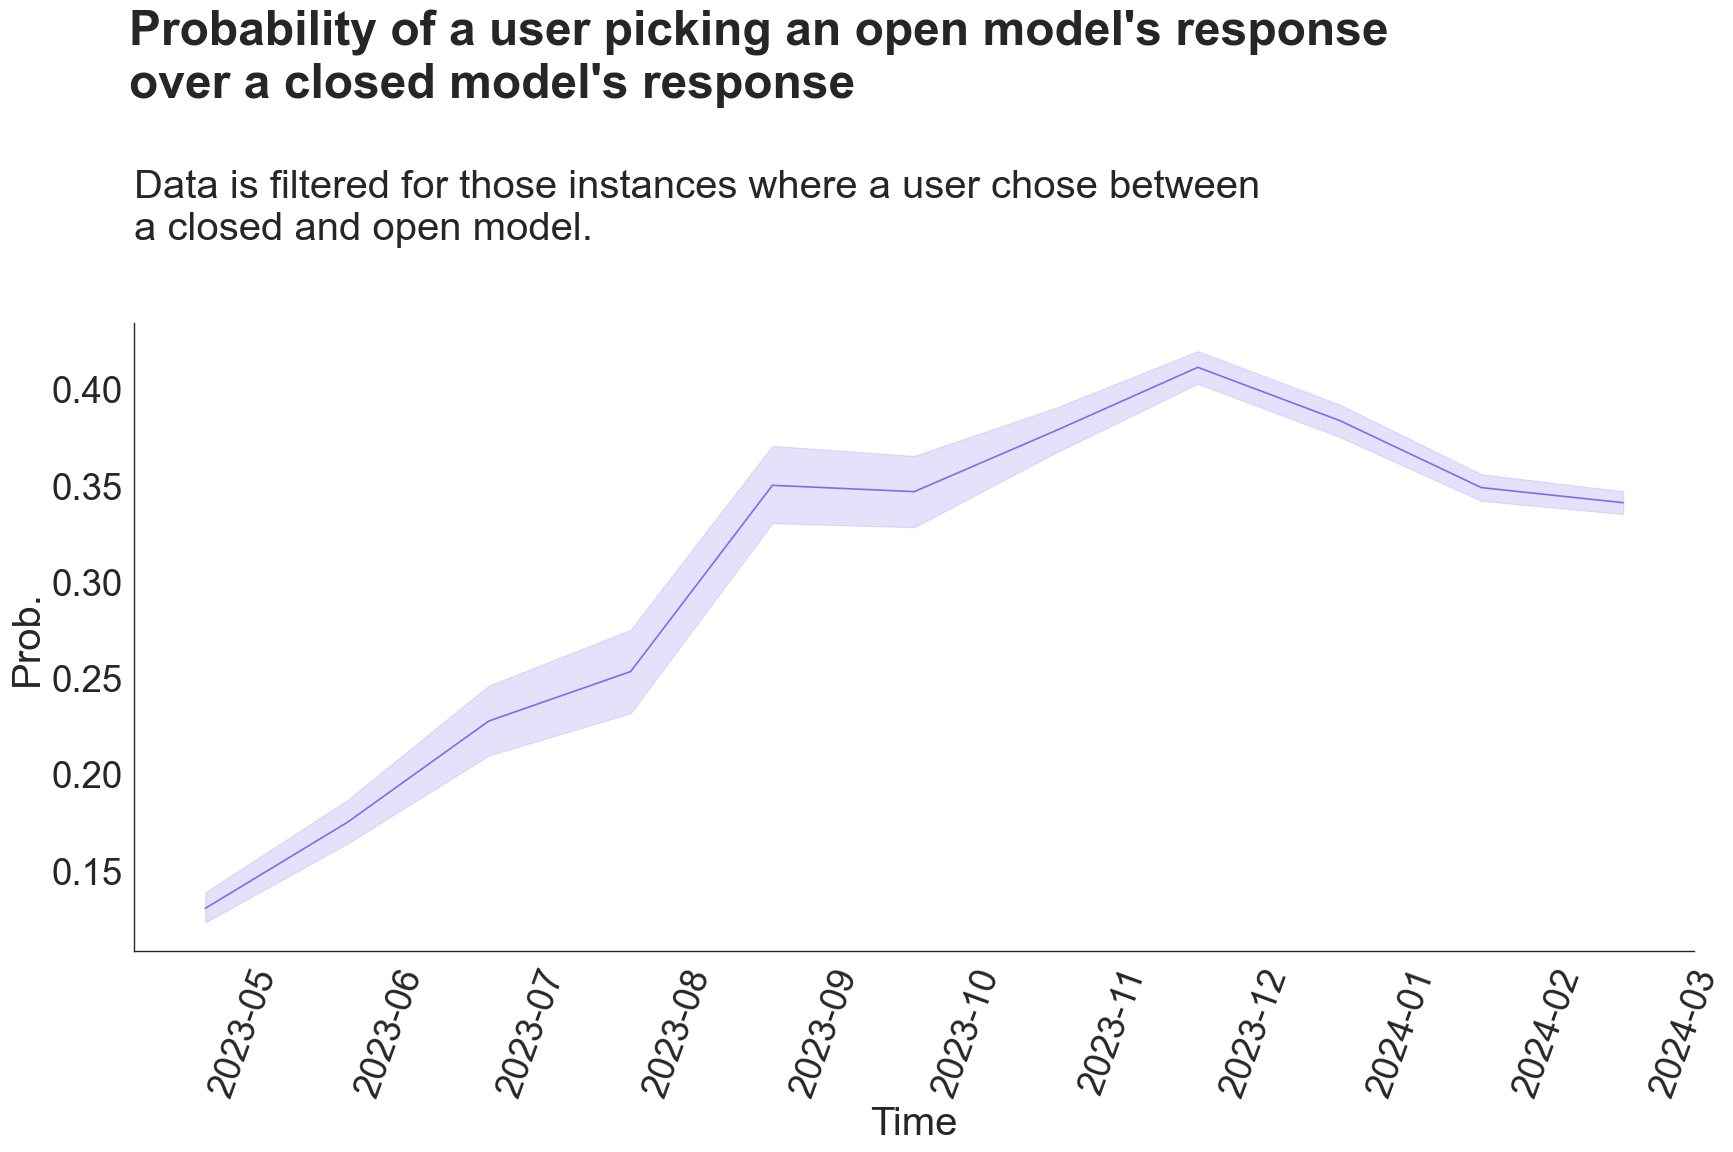

In [13]:
make_aesthetic(font_scale=3)
plt.figure(figsize=(18,12))
sns.lineplot(data=het, x='segment', y='open_won')

plt.suptitle("Probability of a user picking an open model's response\nover a closed model's response", x=0.09, fontweight='bold', ha='left')
plt.title("Data is filtered for those instances where a user chose between\na closed and open model.")

plt.xticks(rotation=70)
plt.ylabel("Prob.")
plt.xlabel("Time")


# Mixed modeling

## Win rates

In [16]:
import statsmodels.formula.api as smf

In [15]:
md = smf.mixedlm("open_won ~ segment_int", het, groups=het["judge"]).fit()
print(md.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: open_won   
No. Observations: 93566   Method:             REML       
No. Groups:       52385   Scale:              0.1990     
Min. group size:  1       Log-Likelihood:     -61297.4659
Max. group size:  279     Converged:          Yes        
Mean group size:  1.8                                    
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.197    0.005 41.023 0.000  0.187  0.206
segment_int     0.017    0.001 31.723 0.000  0.016  0.019
Group Var       0.021    0.002                           



# Report headline rates

In [30]:
def pc(old, new):
    return ((new - old)/old)*100

# Win rates
seg_min = het['segment_int'].min()
seg_max =  het['segment_int'].max()
end_win_rate = het[het['segment_int'] == seg_max]['open_won'].mean()
start_win_rate = het[het['segment_int'] == seg_min]['open_won'].mean()
wr_change = np.round(end_win_rate/start_win_rate)
wr_max_data = het.groupby(by=['segment'])['open_won'].mean().sort_values(ascending=False).head(1).reset_index()
wr_max_date = wr_max_data['segment'].tolist()[0]
wr_max_val = wr_max_data['open_won'].tolist()[0]

# Elos
bootstrap_df['segment_int'] = pd.factorize(bootstrap_df['segment'])[0]
seg_min = bootstrap_df['segment_int'].min()
seg_max =  bootstrap_df['segment_int'].max()
end_closed = bootstrap_df[bootstrap_df['segment_int']==seg_max]['mean_closed'].tolist()[0]
end_open = bootstrap_df[bootstrap_df['segment_int']==seg_max]['mean_open'].tolist()[0]
start_closed = bootstrap_df[bootstrap_df['segment_int']==seg_min]['mean_closed'].tolist()[0]
start_open = bootstrap_df[bootstrap_df['segment_int']==seg_min]['mean_open'].tolist()[0]

pc_closed = np.round(pc(start_closed, end_closed))
pc_open = np.round(pc(start_open, end_open))

print()
print("Start of study", df['tstamp_fix'].min())
print("End of study", df['tstamp_fix'].max())

print()
print("Number of battles", len(df))
print("Number of users", df['judge'].nunique())

print()
print("Wr start", np.round(start_win_rate*100))
print("Wr end", np.round(end_win_rate*100))
print("Wr change ratio", wr_change)

print("Wr max", np.round(wr_max_val*100))
print("Wr max date", wr_max_date)

print()
print("Closed elo change", pc_closed)
print("Open elo change", pc_open)





Start of study 2023-04-24 15:53:11.132200003
End of study 2024-03-13 07:26:02.587899923

Number of battles 369564
Number of users 130662

Wr start 13.0
Wr end 34.0
Wr change ratio 3.0
Wr max 41.0
Wr max date 2023-11-19 00:00:00

Closed elo change -5.0
Open elo change 12.0


# Scrap/WIP

## Anon Analysis -- do certain models get lift when not anonymous?
Looks like weirdly closed models/famous models are chosen less once you know it's one of them, but the effect is very small.

In [36]:
df2 = pd.read_json("clean_battle_20240313.json", dtype={'tstamp':'object'})
meta_df = pd.read_csv("model_names_annot.csv")

for col in meta_df.columns:
    meta_df[col] = meta_df[col].apply(lambda x: x.strip())
    meta_df[f"a_{col}"] = meta_df[col]
    meta_df[f"b_{col}"] = meta_df[col]

df2 = pd.merge(df2, meta_df[['a_short_name', 'a_open_or_closed', "a_long_name"]], left_on=['model_a'], right_on=['a_long_name'])
df2 = pd.merge(df2, meta_df[['b_short_name', 'b_open_or_closed', "b_long_name"]], left_on=['model_b'], right_on=['b_long_name'])

anon_df = df2[df2['anony']==True]
non_anon_df = df2[df2['anony']==False]

elo_anon = pd.DataFrame(compute_mle_elo(anon_df)).reset_index()
elo_anon.columns = ['model', 'elo']
elo_anon['anon'] = [1]*len(elo_anon)

elo_non_anon = pd.DataFrame(compute_mle_elo(non_anon_df)).reset_index()
elo_non_anon.columns = ['model', 'elo']
elo_non_anon['anon'] = [0]*len(elo_anon)
fe = pd.concat([elo_anon, elo_non_anon])

fe['count'] = fe.groupby(by=['model'])['model'].transform('count')
fe = fe.query("count==2")
pivot_df = fe.pivot_table(index='model', columns='anon', values='elo')
pivot_df.columns = ['anon_elo', 'non_anon_elo']
pivot_df = pivot_df.reset_index()

pivot_df = pd.merge(pivot_df, meta_df[['long_name', 'open_or_closed']], left_on=['model'], right_on=['long_name']).query("open_or_closed != '-1'")
pivot_df['anon_change'] = ((pivot_df['non_anon_elo'] - pivot_df['anon_elo'])/pivot_df['non_anon_elo'])*100


Text(23.244444444444454, 0.5, 'Change')

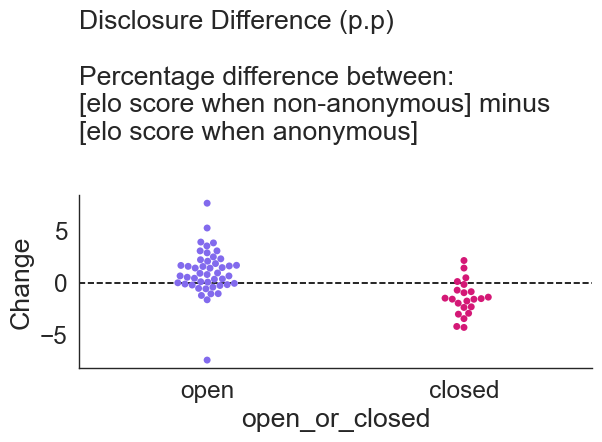

In [44]:
make_aesthetic(font_scale=2)
sns.swarmplot(data=pivot_df, x='open_or_closed', y='anon_change', hue='open_or_closed')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Disclosure Difference (p.p)\n\nPercentage difference between:\n[elo score when non-anonymous] minus \n[elo score when anonymous]", ha='left')
plt.ylabel("Change")

Text(0, 0.5, 'Change')

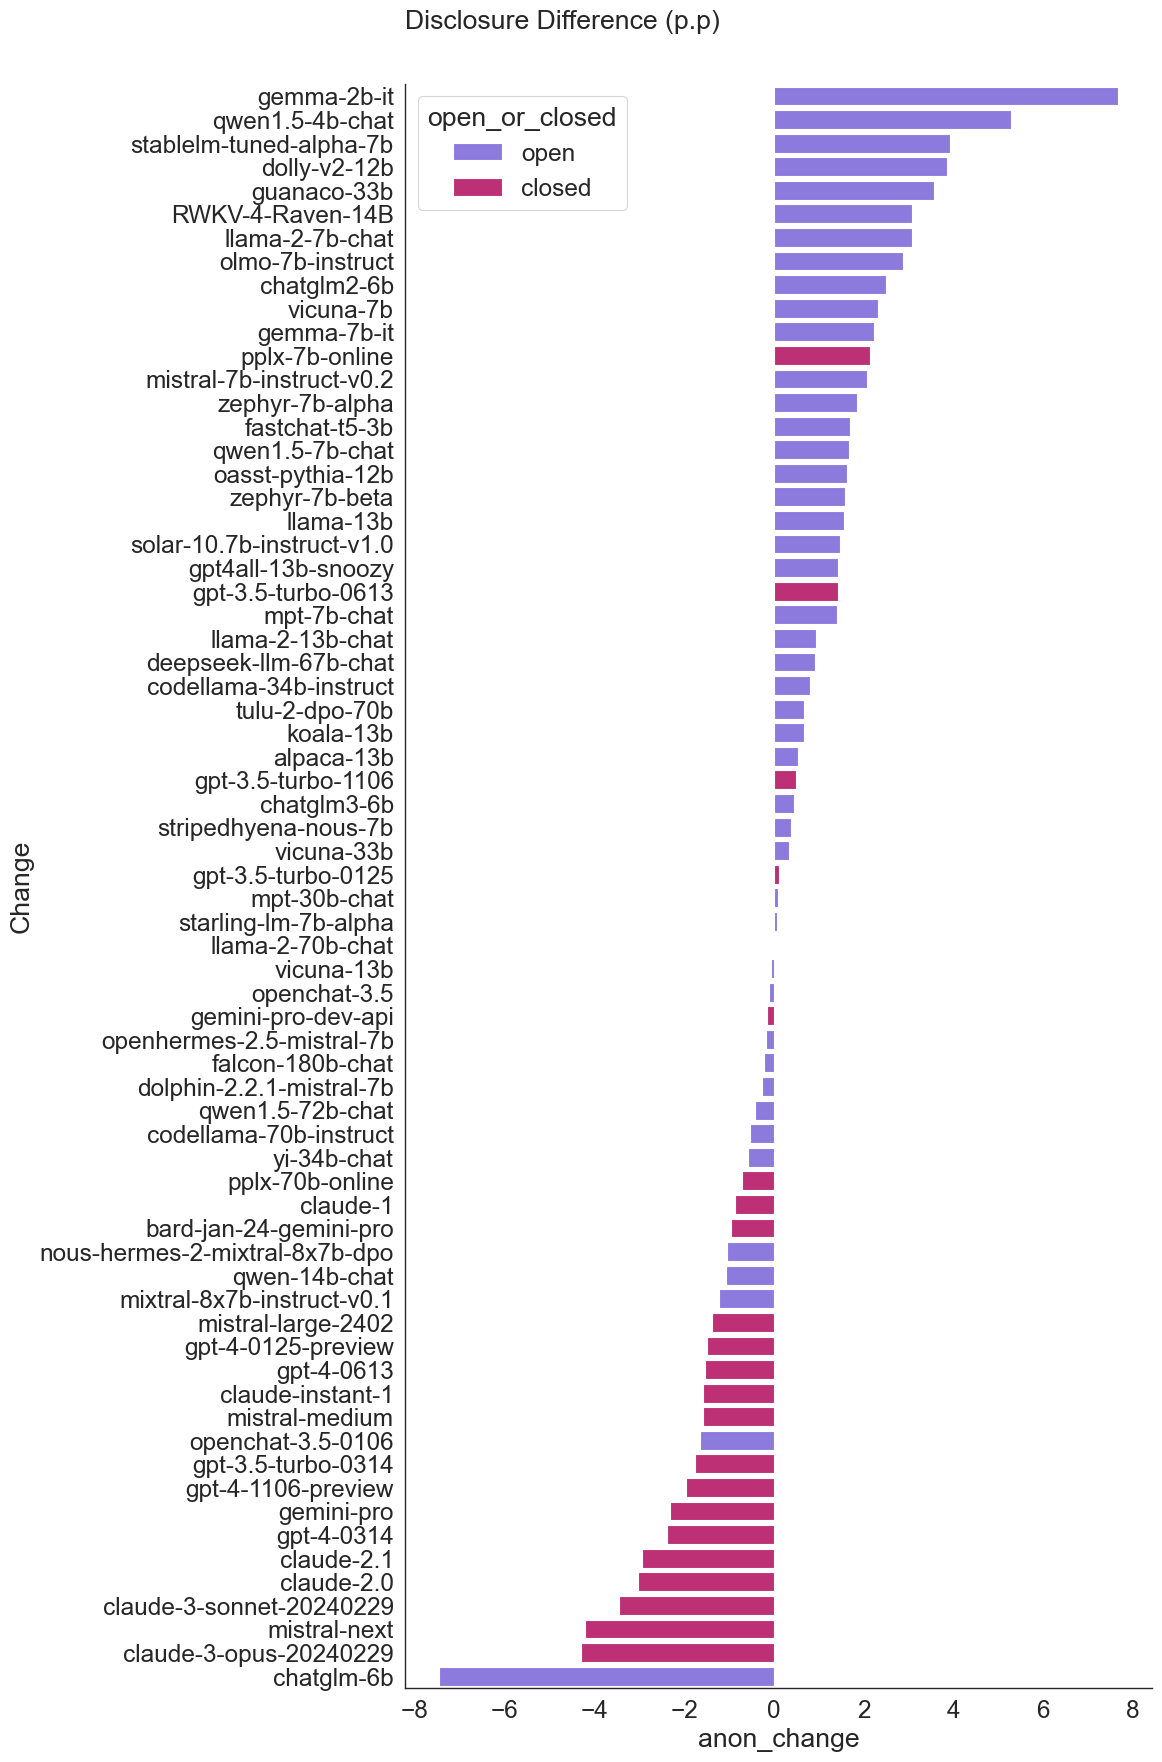

In [45]:
plt.figure(figsize=(12,18))
plt.title("Disclosure Difference (p.p)")
sns.barplot(data=pivot_df.sort_values("anon_change", ascending=False), y='long_name', x='anon_change', hue='open_or_closed')
plt.ylabel("Change")